# Figures for pints publication

In [1]:
import os

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import pints
import seaborn as sns
import xarray as xr
sns.set_theme()

from model import (
    define_hamberg_model,
    define_steady_state_hamberg_model,
    define_hamberg_population_model,
    BaselineINRCovariateModel,
    HambergEliminationRateCovariateModel,
    HambergEC50CovariateModel
)

## Calibration to trial phase I data

Import data

In [2]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(pk_only=True)
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_I.nc')

INFO:root:running build_ext
INFO:root:building 'myokit_sim_1_6923788481803155057' extension
INFO:root:creating build
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/tmpjk2kqx7umyokit
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -iwithsysroot/System/Library/Frameworks/System.framework/PrivateHeaders -iwithsysroot/Applications/Xcode.app/Contents/Develo

Reshape data and compute residuals

In [3]:
# Reshape data
temp = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = temp[temp.ID == _id].Value.values

covariates_1 = np.empty(shape=(len(ids), 2))
covariates_1[:, 0] = data[data.Observable == 'CYP2C9'].Value.values
covariates_1[:, 1] = data[data.Observable == 'Age'].Value.values

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 2))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates_1)

mechanistic_model.set_dosing_regimen(dose=10, start=0)
indiv_fits_1 = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(parameters):
    for idd, indiv_params in enumerate(samples):
        indiv_fits_1[idx, idd] = mechanistic_model.simulate(
            indiv_params, times)[0]

cov_model = HambergEliminationRateCovariateModel()
pop_fits_1 = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(pop_parameters):
    for idd, covs in enumerate(covariates_1):
        log_ke, _ = cov_model.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :])[0, :, 0]
        pop_fits_1[idx, idd] = mechanistic_model.simulate(
            parameters=np.exp([log_ke, samples[5]]), times=times)[0]

Visualise results

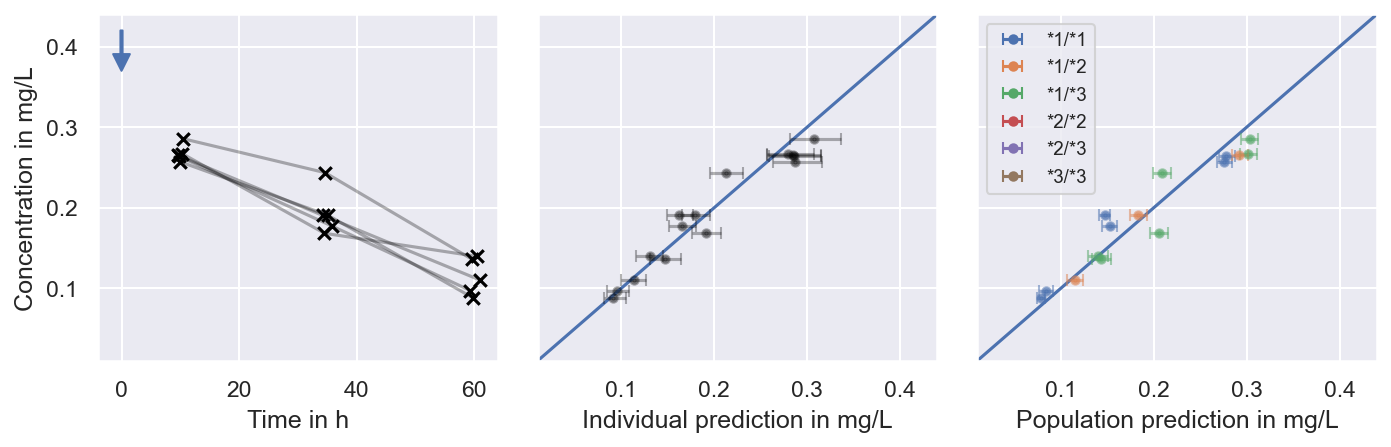

In [7]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for c in concs[:5]:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times + jitter, c, marker='x', color='black')

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.37), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=8, headlength=8, color=sns.color_palette()[0]))

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_1, axis=0)
fifth = medians - np.percentile(indiv_fits_1, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_1, axis=0, q=95) - medians
for idf, f in enumerate(medians[:5]):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_1, axis=0)
fifth = medians - np.percentile(pop_fits_1, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_1, axis=0, q=95) - medians
for idf, f in enumerate(medians[:5]):
    axes[2].errorbar(
        f, concs[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates_1[idf, 0])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, concs[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates_1[idf, 0])])

# Add legend to population residuals
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual prediction in mg/L')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction in mg/L')
axes[2].set_ylabel('')
axes[0].set_xlim([-4, 64])
axes[1].set_ylim([0.01, 0.44])
axes[1].set_xlim([0.01, 0.44])
axes[2].set_ylim([0.01, 0.44])
axes[2].set_xlim([0.01, 0.44])

plt.savefig('pints-figure-hierarchical-fit.pdf', bbox_inches='tight')
plt.savefig('pints-figure-hierarchical-fit.tif', bbox_inches='tight')

plt.show()

Covariate summary

In [103]:
print('Fraction with *1/*1: ', np.sum(covariates_1[:, 0] == 0) / len(covariates_1))
print('Fraction with *1/*2: ', np.sum(covariates_1[:, 0] == 1) / len(covariates_1))
print('Fraction with *1/*3: ', np.sum(covariates_1[:, 0] == 2) / len(covariates_1))
print('Fraction with *2/*2: ', np.sum(covariates_1[:, 0] == 3) / len(covariates_1))
print('Fraction with *2/*3: ', np.sum(covariates_1[:, 0] == 4) / len(covariates_1))
print('Fraction with *3/*3: ', np.sum(covariates_1[:, 0] == 5) / len(covariates_1))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates_1[:, 1]),
        np.percentile(covariates_1[:, 1], q=5),
        np.percentile(covariates_1[:, 1], q=95)))

Fraction with *1/*1:  0.6166666666666667
Fraction with *1/*2:  0.2
Fraction with *1/*3:  0.13333333333333333
Fraction with *2/*2:  0.016666666666666666
Fraction with *2/*3:  0.016666666666666666
Fraction with *3/*3:  0.016666666666666666
Age: 69 (58 - 79)


Visualise posterior distribution

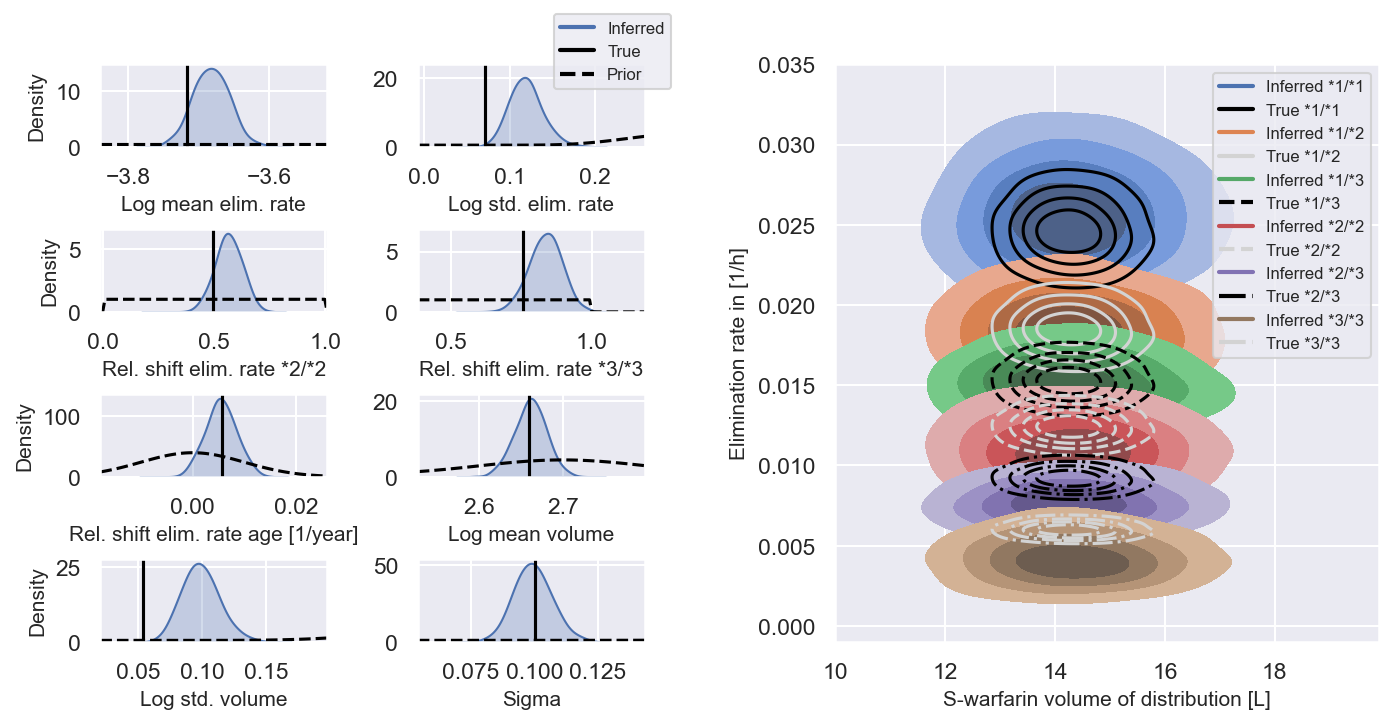

In [7]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.35, width_ratios=[1, 1])

# Create axes for marginal posteriors
axes = []
inner = gridspec.GridSpecFromSubplotSpec(
    4, 2, subplot_spec=outer[0], hspace=1, wspace=0.4)
axes.append(plt.Subplot(fig, inner[0]))
axes.append(plt.Subplot(fig, inner[1]))
axes.append(plt.Subplot(fig, inner[2]))
axes.append(plt.Subplot(fig, inner[3]))
axes.append(plt.Subplot(fig, inner[4]))
axes.append(plt.Subplot(fig, inner[5]))
axes.append(plt.Subplot(fig, inner[6]))
axes.append(plt.Subplot(fig, inner[7]))

# Create axis for IIV parameters
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3, 0.1),       # Mean log clearance
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log clearance
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *2
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0, 0.01),       # Rel. shift clearance Age
    pints.GaussianLogPrior(2.7, 0.1),      # Mean log volume
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)       # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp in [0, 1, 5, 6]:
        evals = np.array(evals) + 0.5
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Plot data-generating distribution as reference to parameter space
true_parameters = [-3.716, 0.071, 0.495, 0.757, 0.00571, 3.353, 0.054, 0.1]
for idx, ax in enumerate(axes[:-1]):
    p = true_parameters[idx]
    if idx == 5:
        p -= np.log(2)
    ax.axvline(x=p, color='black', linestyle='solid')

# Plot inferred population distribution
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(),
    chi.PooledModel()])
parameters = pop_parameters[np.random.choice(
    np.arange(len(pop_parameters)), size=n_samples, replace=True)]

# Define covariates
typical_age = 68
np.random.seed(12)
covariates = np.zeros(shape=(n_samples, 2))
covariates[:, 1] = np.random.lognormal(
    mean=np.log(typical_age), sigma=0.1, size=n_samples)

# Sample subpopulations
styles = ['solid', 'solid', 'dashed', 'dashed', 'dashdot', 'dashdot']
colors = ['black', 'lightgrey', 'black', 'lightgrey', 'black', 'lightgrey']
for idc, cyp in enumerate([0, 1, 2, 3, 4, 5]):
    covariates[:, 0] = cyp
    samples = np.empty(shape=(n_samples, 3))
    for ids, params in enumerate(parameters):
        cov = covariates[ids:ids+1]
        samples[ids, :] = population_model.sample(
            params, seed=seed, covariates=cov)[0]
    sns.kdeplot(
        x=samples[:, 1], y=samples[:, 0], fill=True, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[-1])

    # Plot data-generating distribution as reference to parameter space
    samples = population_model.sample(
        true_parameters, n_samples, seed=1, covariates=covariates)
    sns.kdeplot(
        x=samples[:, 1] / 2, y=samples[:, 0], fill=False, bw_adjust=1.5,
        color=colors[idc], levels=[0.2, 0.4, 0.6, 0.8, 1],
        ax=axes[-1], linestyles=styles[idc])

# Add legends
axes[1].set_ylim([0, 24])
axes[1].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='True', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Prior', linewidth=2)
axes[1].legend(loc=[0.6, 0.7], fontsize=int(0.8 * fontsize))

axes[-1].set_ylim([-0.001, 0.035])
axes[-1].set_xlim([10, 19.9])
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=sns.color_palette()[idl],
        label='Inferred %s' % label, linewidth=2)
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=colors[idl], linestyle=styles[idl],
        label='True %s' % label, linewidth=2)
axes[-1].legend(fontsize=int(0.8 * fontsize))


# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('Density', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('Density', fontsize=fontsize)
axes[5].set_xlabel('Log mean volume', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel('Log std. volume', fontsize=fontsize)
axes[6].set_ylabel('Density', fontsize=fontsize)
axes[7].set_xlabel('Sigma', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)
axes[8].set_ylabel('Elimination rate in [1/h]', fontsize=fontsize)
axes[8].set_xlabel('S-warfarin volume of distribution [L]', fontsize=fontsize)

plt.savefig('2_trial_phase_1_parameter_space.pdf', bbox_inches='tight')
plt.savefig('2_trial_phase_1_parameter_space.tif', bbox_inches='tight')

plt.show()

Find prior distributions for inference from trial phase II

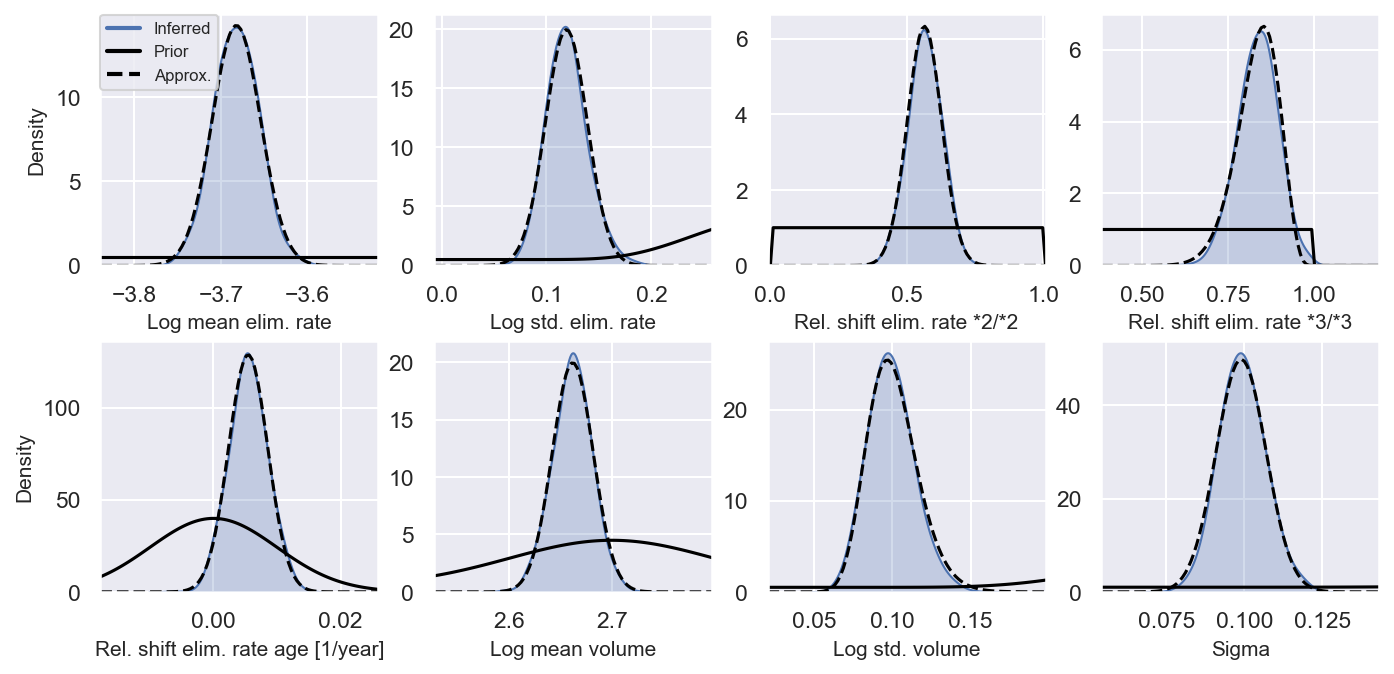

In [69]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 4, wspace=0.2, hspace=0.3)

# Create axes for marginal posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes.append(plt.Subplot(fig, outer[4]))
axes.append(plt.Subplot(fig, outer[5]))
axes.append(plt.Subplot(fig, outer[6]))
axes.append(plt.Subplot(fig, outer[7]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3, 0.1),       # Mean log clearance
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log clearance
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *2
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0, 0.01),       # Rel. shift clearance Age
    pints.GaussianLogPrior(2.7, 0.1),      # Mean log volume
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)       # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp in [0, 1, 5, 6]:
        evals = np.array(evals) + 0.5
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='solid')
    axes[idp].set_xlim([min_value, max_value])

# Plot approximate posteriors
log_priors = [
    pints.GaussianLogPrior(-3.682, 0.028),    # Mean log clearance
    pints.GaussianLogPrior(0.119, 0.02),      # Sigma log clearance
    pints.GaussianLogPrior(0.565, 0.063),     # Rel. shift clearance CYP29P *2
    pints.BetaLogPrior(30, 6),                # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00546, 0.0031),  # Rel. shift clearance Age
    pints.GaussianLogPrior(2.662, 0.02),      # Mean log volume
    pints.LogNormalLogPrior(-2.31, 0.16),     # Sigma log volume
    pints.GaussianLogPrior(0.099, 0.008)      # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Add legends
axes[0].set_ylim([0, 14.9])
axes[0].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[0].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='Prior', linewidth=2)
axes[0].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Approx.', linewidth=2)
axes[0].legend(loc=[0, 0.7], fontsize=int(0.8 * fontsize))

# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('Density', fontsize=fontsize)
axes[5].set_xlabel('Log mean volume', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel('Log std. volume', fontsize=fontsize)
axes[6].set_ylabel('', fontsize=fontsize)
axes[7].set_xlabel('Sigma', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)

plt.savefig('2_trial_phase_1_approximate_posteriors.pdf', bbox_inches='tight')
plt.savefig('2_trial_phase_1_approximate_posteriors.tif', bbox_inches='tight')

plt.show()

## Calibration to trial phase II data

Import data

In [2]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_II.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(baseline_inr=None)
mechanistic_model.set_outputs(['myokit.inr'])
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        BaselineINRCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_II.nc')

INFO:root:running build_ext
INFO:root:building 'myokit_sim_1_6937153593593091285' extension
INFO:root:creating build
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/tmpagwnqfuemyokit
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -iwithsysroot/System/Library/Frameworks/System.framework/PrivateHeaders -iwithsysroot/Applications/Xcode.app/Contents/Develo

Reshape data

In [9]:
# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
times2 = temp.Time.dropna().unique() // 24
inrs2 = np.empty(shape=(len(ids), len(times2)))
doses = np.empty(shape=(len(ids), int(times2[-1])))
covariates_2 = np.empty(shape=(len(ids), 4))
for idx, _id in enumerate(ids):
    inrs2[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses[idx] = data[mask].Dose.dropna().values
    covariates_2[idx, 0] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]
    covariates_2[idx, 1] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates_2[idx, 2] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates_2[idx, 3] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.baseline_inr'].values.flatten(),
    posterior['Log std. myokit.baseline_inr'].values.flatten(),
    posterior['Rel. baseline INR A'].values.flatten(),
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.baseline_inr'].values,
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.half_maximal_effect_concentration'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 6))
parameters[:, :, 3] = pop_parameters[:, 11][:, np.newaxis]
parameters[:, :, 4] = pop_parameters[:, 12][:, np.newaxis]
pop_p = pop_parameters[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14]]
for idx in range(n_samples):
    p = population_model.compute_individual_parameters(
        parameters=pop_p[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates_2)
    parameters[idx, :, 0] = p[:, 0]
    parameters[idx, :, 1] = p[:, 1]
    parameters[idx, :, 2] = p[:, 2]
    parameters[idx, :, 5] = p[:, 3]

duration = 0.01
# indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
indiv_fits_2 = np.empty(shape=(100, len(ids), len(times2)))
for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
    mechanistic_model.set_dosing_regimen(regimen)
    for idx, sample in enumerate(indiv_params[:100]):
        indiv_fits_2[idx, idd] = mechanistic_model.simulate(
            sample, times2*24)[0]

cov_model0 = BaselineINRCovariateModel()
cov_model1 = HambergEliminationRateCovariateModel()
cov_model2 = HambergEC50CovariateModel()
# pop_fits = np.empty(shape=(n_samples, len(ids), len(times2)))
pop_fits_2 = np.empty(shape=(100, len(ids), len(times2)))
for idd, covs in enumerate(covariates_2):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
    mechanistic_model.set_dosing_regimen(regimen)
    for idx, samples in enumerate(pop_parameters[:100]):
        log_y0, _ = cov_model0.compute_population_parameters(
            parameters=samples[2:3],
            pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :1])[0, :, 0]
        log_ke, _ = cov_model1.compute_population_parameters(
            parameters=samples[5:8],
            pop_parameters=samples[3:5][:, np.newaxis],
            covariates=covs[np.newaxis, 1:3])[0, :, 0]
        log_ec50, _ = cov_model2.compute_population_parameters(
            parameters=samples[10:11],
            pop_parameters=samples[8:10][:, np.newaxis],
            covariates=covs[np.newaxis, 3:])[0, :, 0]
        pop_fits_2[idx, idd] = mechanistic_model.simulate(
            parameters=[
                np.exp(log_y0),
                np.exp(log_ke),
                np.exp(log_ec50),
                samples[11],
                samples[12],
                np.exp(samples[13])
                ],
            times=times2*24)[0]

Visualise results

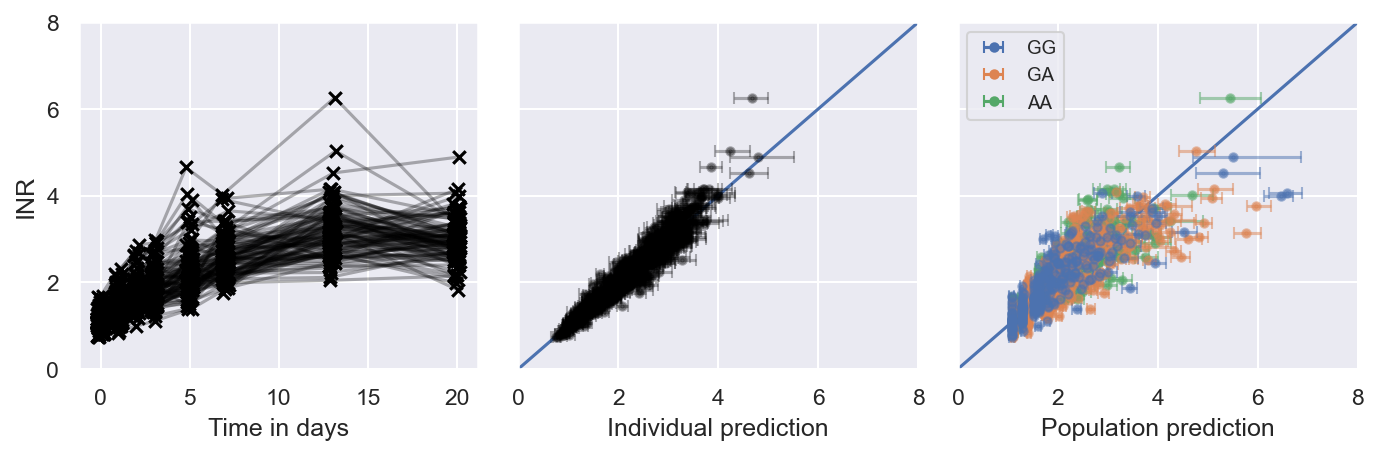

In [13]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for c in inrs2:
    jitter = np.random.uniform(-0.2, 0.2, size=len(times2))
    axes[0].plot(
        times2 + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times2 + jitter, c, marker='x', color='black')

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_2, axis=0)
fifth = medians - np.percentile(indiv_fits_2, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_2, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, inrs2[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, inrs2[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_2, axis=0)
fifth = medians - np.percentile(pop_fits_2, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_2, axis=0, q=95) - medians
covs = covariates_2[:, 1:]
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, inrs2[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covs[idf, 2])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, inrs2[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covs[idf, 2])])

# Add legend to population residuals
labels = ['GG', 'GA', 'AA']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in days')
axes[0].set_ylabel('INR')
axes[1].set_xlabel('Individual prediction')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction')
axes[2].set_ylabel('')
axes[0].set_ylim([0, 8])
axes[1].set_xlim([0, 8])
axes[2].set_xlim([0, 8])

plt.savefig('pints-figure-hierarchical-fit.pdf', bbox_inches='tight')
plt.savefig('pints-figure-hierarchical-fit.tif', bbox_inches='tight')

plt.show()

Plot fit of 5 individuals

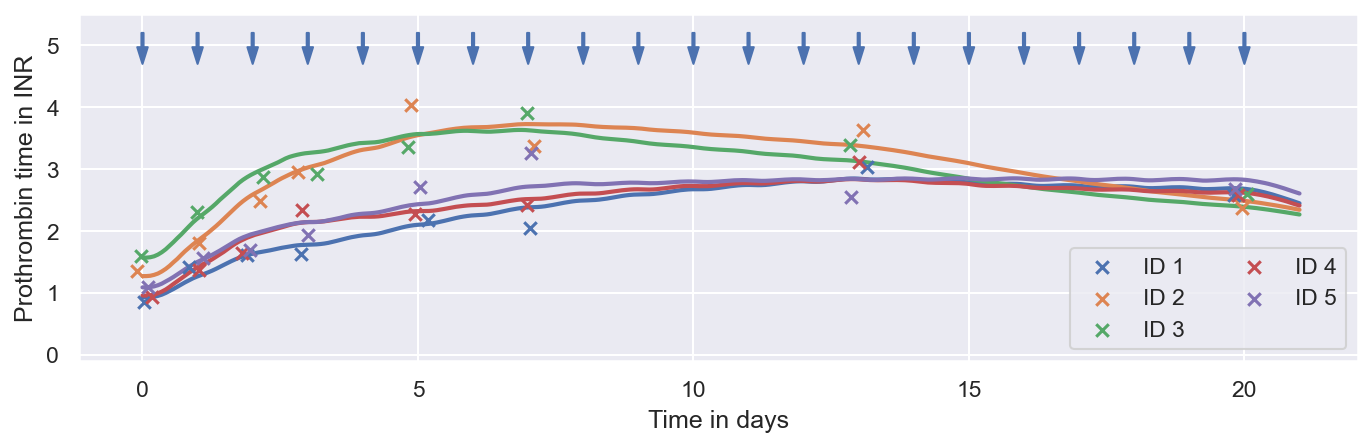

In [44]:
# selected_ids = ids[[0, 1, 2, 3, 4]]
# times = np.linspace(0, 21, num=300)
# fits = np.empty(shape=(100, len(ids), len(times)))
# for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
#     # Set dosing regimen
#     regimen = myokit.Protocol()
#     for day, dose in enumerate(doses[idd]):
#         dose_rate = dose / duration
#         regimen.add(myokit.ProtocolEvent(
#             level=dose_rate, start=day*24, duration=duration))
#     mechanistic_model.set_dosing_regimen(regimen)
#     for idx, sample in enumerate(indiv_params[:100]):
#         fits[idx, idd] = mechanistic_model.simulate(
#             sample, times*24)[0]

# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=1, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for _id in selected_ids:    
    # Plot fit
    medians = np.median(fits[:, _id], axis=0)
    plt.plot(times, medians, color=sns.color_palette()[_id], linewidth=2)

    c = inrs2[_id]
    jitter = np.random.uniform(-0.2, 0.2, size=len(times2))
    axes.scatter(
        times2 + jitter, c, marker='x', color=sns.color_palette()[_id], 
        label=f'ID {_id + 1}', zorder=10)

# Visualise dosing regimen
for t in np.arange(21):
    axes.annotate(
        "", xy=(t, 4.7), xytext=(t, 5.2),
        arrowprops=dict(width=1, headwidth=5, headlength=8,
        color=sns.color_palette()[0]))

axes.set_ylim([-0.1, 5.5])
axes.set_xlabel('Time in days')
axes.set_ylabel('Prothrombin time in INR')
axes.legend(ncols=2, loc='lower right')

plt.savefig('pints-figure-hierarchical-fit.pdf', bbox_inches='tight')
plt.savefig('pints-figure-hierarchical-fit.tif', bbox_inches='tight')

plt.show()

INFO:root:running build_ext
INFO:root:building 'myokit_sim_13_1929011179998792568' extension
INFO:root:creating build
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T
INFO:root:creating build/temp.macosx-10.9-universal2-cpython-39/var/folders/v4/97p50d2s59d8tf5xm5h27fjh0000gp/T/tmp5rvnrlp0myokit
INFO:root:clang -Wno-unused-result -Wsign-compare -Wunreachable-code -fno-common -dynamic -DNDEBUG -g -fwrapv -O3 -Wall -iwithsysroot/System/Library/Frameworks/System.framework/PrivateHeaders -iwithsysroot/Applications/Xcode.app/Contents/Devel

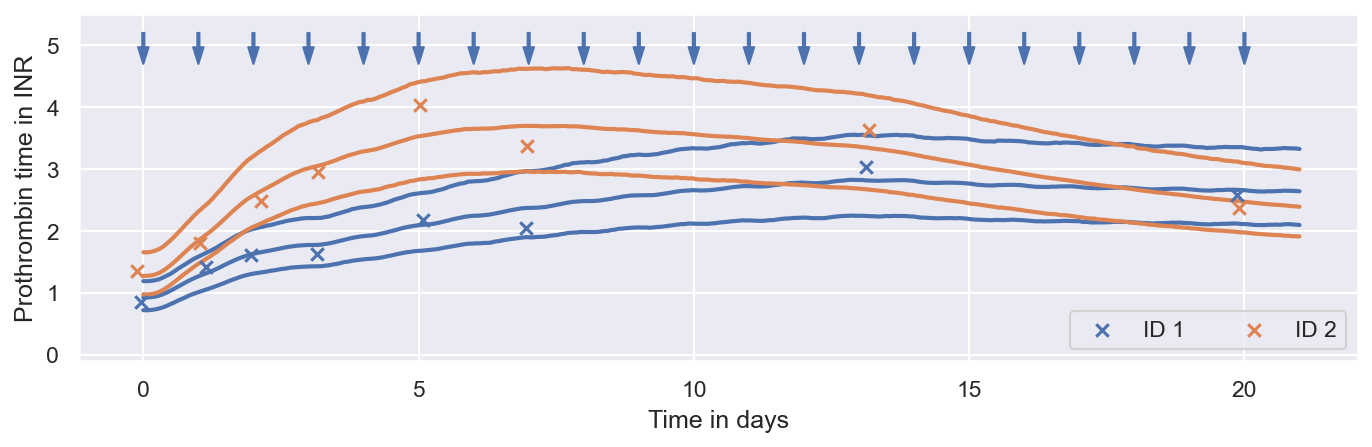

In [36]:
# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
times2 = temp.Time.dropna().unique() // 24
inrs2 = np.empty(shape=(len(ids), len(times2)))
doses = np.empty(shape=(len(ids), int(times2[-1])))
covariates_2 = np.empty(shape=(len(ids), 4))
for idx, _id in enumerate(ids):
    inrs2[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses[idx] = data[mask].Dose.dropna().values
    covariates_2[idx, 0] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]
    covariates_2[idx, 1] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates_2[idx, 2] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates_2[idx, 3] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.baseline_inr'].values.flatten(),
    posterior['Log std. myokit.baseline_inr'].values.flatten(),
    posterior['Rel. baseline INR A'].values.flatten(),
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.baseline_inr'].values,
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.half_maximal_effect_concentration'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 7))
parameters[:, :, 3] = pop_parameters[:, 11][:, np.newaxis]
parameters[:, :, 4] = pop_parameters[:, 12][:, np.newaxis]
parameters[:, :, 6] = pop_parameters[:, 15][:, np.newaxis]
pop_p = pop_parameters[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14]]
for idx in range(n_samples):
    p = population_model.compute_individual_parameters(
        parameters=pop_p[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates_2)
    parameters[idx, :, 0] = p[:, 0]
    parameters[idx, :, 1] = p[:, 1]
    parameters[idx, :, 2] = p[:, 2]
    parameters[idx, :, 5] = p[:, 3]

# Define predictive model
model = chi.PredictiveModel(mechanistic_model, chi.LogNormalErrorModel())

times = np.linspace(0, 21, num=300)
n_samples = 100
fits = np.empty(shape=(1000, 2, len(times), n_samples))
for idd, indiv_params in enumerate(
        np.swapaxes(parameters[:, :2], axis1=0, axis2=1)):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
        if day == 19:
            # This is just for visuale purposes
            regimen.add(myokit.ProtocolEvent(
                level=dose_rate, start=(day+1)*24, duration=duration))
    model.set_dosing_regimen(regimen)
    for idx, sample in enumerate(indiv_params):
        fits[idx, idd] = model.sample(
            sample, times*24, n_samples=n_samples, return_df=False)[0, :]

# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=1, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for _id in [0, 1]:    
    # Plot fit
    medians = np.median(fits[:, _id], axis=(0, 2))
    plt.plot(times, medians, color=sns.color_palette()[_id], linewidth=2)
    low = np.percentile(fits[:, _id], q=2.5, axis=(0, 2))
    plt.plot(times, low, color=sns.color_palette()[_id], linewidth=2)
    high = np.percentile(fits[:, _id], q=97.5, axis=(0, 2))
    plt.plot(times, high, color=sns.color_palette()[_id], linewidth=2)

    c = inrs2[_id]
    jitter = np.random.uniform(-0.2, 0.2, size=len(times2))
    axes.scatter(
        times2 + jitter, c, marker='x', color=sns.color_palette()[_id], 
        label=f'ID {_id + 1}', zorder=10)

# Visualise dosing regimen
for t in np.arange(21):
    axes.annotate(
        "", xy=(t, 4.7), xytext=(t, 5.2),
        arrowprops=dict(width=1, headwidth=5, headlength=8,
        color=sns.color_palette()[0]))

axes.set_ylim([-0.1, 5.5])
axes.set_xlabel('Time in days')
axes.set_ylabel('Prothrombin time in INR')
axes.legend(ncols=2, loc='lower right')

plt.show()

Export data

In [10]:
df_meas = pd.DataFrame({
    'ID': [ids[0] + 1] * len(times2),
    'Time': times2,
    'Actual data': inrs2[0],
})
df_meas = pd.concat([df_meas, pd.DataFrame({
    'ID': [ids[1] + 1] * len(times2),
    'Time': times2,
    'Actual data': inrs2[1],
})])
df_meas = pd.concat([df_meas, pd.DataFrame({
    'ID': [ids[0] + 1] * len(times),
    'Time': times,
    '2.5%': np.percentile(fits[:, 0], q=2.5, axis=(0, 2)),
    '50%': np.percentile(fits[:, 0], q=50, axis=(0, 2)),
    '97.5%': np.percentile(fits[:, 0], q=97.5, axis=(0, 2)),
})])
df_meas = pd.concat([df_meas, pd.DataFrame({
    'ID': [ids[1] + 1] * len(times),
    'Time': times,
    '2.5%': np.percentile(fits[:, 1], q=2.5, axis=(0, 2)),
    '50%': np.percentile(fits[:, 1], q=50, axis=(0, 2)),
    '97.5%': np.percentile(fits[:, 1], q=97.5, axis=(0, 2)),
})])
df_meas.to_csv('pints-model-fits.csv')

Plot ESS

In [45]:
posterior

<xarray.Dataset>
Dimensions:                                            (chain: 1, draw: 1000,
                                                        individual: 100)
Coordinates:
  * chain                                              (chain) int64 0
  * draw                                               (draw) int64 500 ... 1499
  * individual                                         (individual) object '0...
Data variables: (12/20)
    Log mean myokit.baseline_inr                       (chain, draw) float64 ...
    Log std. myokit.baseline_inr                       (chain, draw) float64 ...
    Rel. baseline INR A                                (chain, draw) float64 ...
    Log mean myokit.elimination_rate                   (chain, draw) float64 ...
    Log std. myokit.elimination_rate                   (chain, draw) float64 ...
    Rel. elimination rate shift *2*2                   (chain, draw) float64 ...
    ...                                                 ...
    Log std. myokit.volume                             (chain, draw) float64 ...
    Pooled Sigma log                                   (chain, draw) float64 ...
    myokit.baseline_inr                                (chain, draw, individual) float64 ...
    myokit.elimination_rate                            (chain, draw, individual) float64 ...
    myokit.half_maximal_effect_concentration           (chain, draw, individual) float64 ...
    myokit.volume                                      (chain, draw, individual) float64 ...
Attributes:
    divergent iterations:          true
    divergent iterations chain 0:  [  1   2   3   4   5   6   7   8   9  10  ...

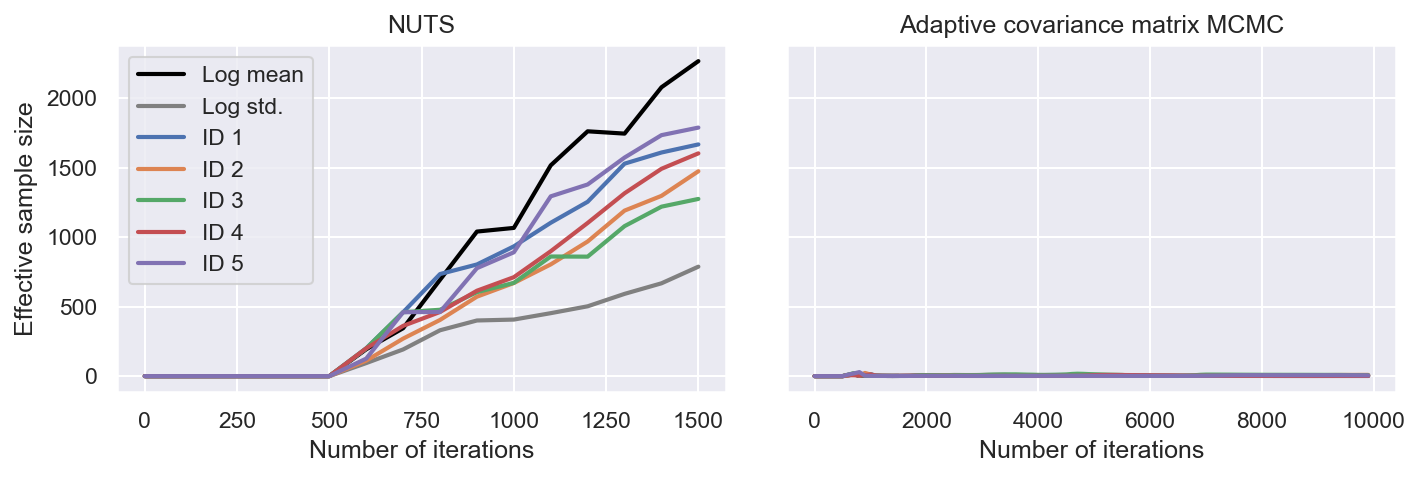

In [124]:
import arviz as az

# Import inference results
directory = os.getcwd()
posterior_acmc = xr.load_dataset(
    directory + '/posteriors/pints-posterior_trial_phase_II.nc')

# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

parameter = 'Log mean myokit.volume'
iterations = np.arange(16) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

axes[0].plot(iterations, ess, color='black', linewidth=2, label='Log mean')

parameter = 'Log std. myokit.volume'
iterations = np.arange(16) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

axes[0].plot(iterations, ess, color='grey', linewidth=2, label='Log std.')

parameter = 'myokit.volume'
for _id in selected_ids:
    ess = []
    for iteration in iterations:
        e = az.ess(posterior[parameter].sel(
            draw=slice(0, iteration), 
            individual=str(_id)))
        e = float(e[parameter].values)
        if np.isnan(e):
            e = 0
        ess.append(e)

    axes[0].plot(
        iterations, ess, color=sns.color_palette()[_id], linewidth=2, 
        label=f'ID {_id + 1}')
    
parameter = 'Log mean myokit.volume'
iterations = np.arange(16) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior_acmc[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

axes[1].plot(iterations, ess, color='black', linewidth=2, label='Log mean')

parameter = 'Log std. myokit.volume'
iterations = np.arange(100) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior_acmc[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

axes[1].plot(iterations, ess, color='grey', linewidth=2, label='Log std.')

parameter = 'myokit.volume'
for _id in selected_ids:
    ess = []
    for iteration in iterations:
        e = az.ess(posterior_acmc[parameter].sel(
            draw=slice(0, iteration), 
            individual=str(_id)))
        e = float(e[parameter].values)
        if np.isnan(e):
            e = 0
        ess.append(e)

    axes[1].plot(
        iterations, ess, color=sns.color_palette()[_id], linewidth=2, 
        label=f'ID {_id + 1}')

axes[0].legend()
axes[0].set_xlabel('Number of iterations')
axes[0].set_ylabel('Effective sample size')
axes[1].set_xlabel('Number of iterations')
axes[0].set_title('NUTS')
axes[1].set_title('Adaptive covariance matrix MCMC')

plt.savefig('pints-figure-hierarchical-fit-ess.pdf', bbox_inches='tight')
plt.savefig('pints-figure-hierarchical-fit-ess.tif', bbox_inches='tight')

plt.show()

In [131]:
parameter = 'Log mean myokit.volume'
iterations = np.arange(16) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

df = pd.DataFrame({
    'Iteration': iterations,
    'Parameter': [parameter] * len(iterations),
    'ESS': ess,
})

parameter = 'Log std. myokit.volume'
iterations = np.arange(16) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

df = pd.concat([df, pd.DataFrame({
    'Iteration': iterations,
    'Parameter': [parameter] * len(iterations),
    'ESS': ess,
})])

parameter = 'myokit.volume'
for _id in selected_ids[:2]:
    ess = []
    for iteration in iterations:
        e = az.ess(posterior[parameter].sel(
            draw=slice(0, iteration), 
            individual=str(_id)))
        e = float(e[parameter].values)
        if np.isnan(e):
            e = 0
        ess.append(e)

    df = pd.concat([df, pd.DataFrame({
        'Iteration': iterations,
        'Parameter': [parameter + f'ID {_id + 1}'] * len(iterations),
        'ESS': ess,
    })])

df.to_csv('pints-nuts-ess.csv')
    
parameter = 'Log mean myokit.volume'
iterations = np.arange(100) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior_acmc[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

df = pd.DataFrame({
    'Iteration': iterations,
    'Parameter': [parameter] * len(iterations),
    'ESS': ess,
})

parameter = 'Log std. myokit.volume'
iterations = np.arange(100) * 100
ess = []
for iteration in iterations:
    e = az.ess(posterior_acmc[parameter].sel(draw=slice(0, iteration)))
    e = float(e[parameter].values)
    if np.isnan(e):
        e = 0
    ess.append(e)

df = pd.concat([df, pd.DataFrame({
    'Iteration': iterations,
    'Parameter': [parameter] * len(iterations),
    'ESS': ess,
})])

parameter = 'myokit.volume'
for _id in selected_ids[:2]:
    ess = []
    for iteration in iterations:
        e = az.ess(posterior_acmc[parameter].sel(
            draw=slice(0, iteration), 
            individual=str(_id)))
        e = float(e[parameter].values)
        if np.isnan(e):
            e = 0
        ess.append(e)

    df = pd.concat([df, pd.DataFrame({
        'Iteration': iterations,
        'Parameter': [parameter + f'ID {_id + 1}'] * len(iterations),
        'ESS': ess,
    })])

df.to_csv('pints-acmc-ess.csv')

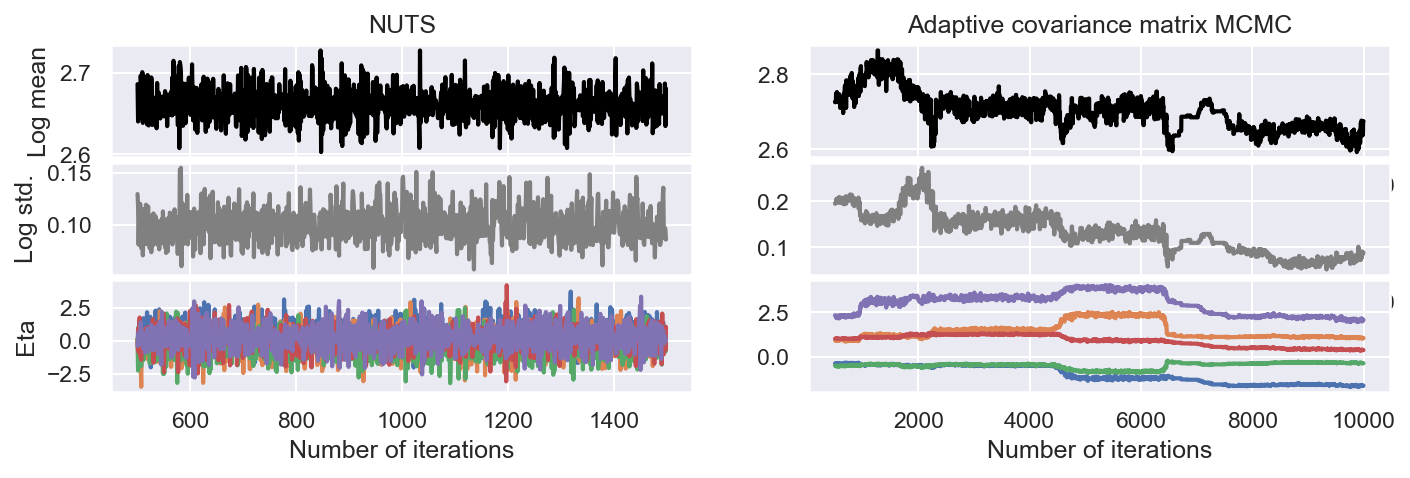

In [126]:
import arviz as az

# Import inference results
directory = os.getcwd()
posterior_acmc = xr.load_dataset(
    directory + '/posteriors/pints-posterior_trial_phase_II.nc')

# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=False, sharex=False, gridspec_kw=dict(wspace=0.2,  hspace=0.05))

parameter = 'Log mean myokit.volume'
iterations = np.arange(500, 1500)
axes[0, 0].plot(iterations, posterior[parameter].values[0], color='black', linewidth=2, label='Log mean')

parameter = 'Log std. myokit.volume'
axes[1, 0].plot(iterations, posterior[parameter].values[0], color='grey', linewidth=2, label='Log std.')

parameter = 'myokit.volume'
for _id in selected_ids:
    samples = posterior[parameter].sel(
        individual=str(_id)).values[0]
    axes[2, 0].plot(
        iterations, samples, color=sns.color_palette()[_id], linewidth=2, 
        label=f'ID {_id + 1}')
    
parameter = 'Log mean myokit.volume'
iterations = np.arange(500, 10000)
axes[0, 1].plot(iterations, posterior_acmc[parameter].values[0], color='black', linewidth=2, label='Log mean')

parameter = 'Log std. myokit.volume'
axes[1, 1].plot(iterations, posterior_acmc[parameter].values[0], color='grey', linewidth=2, label='Log std.')

parameter = 'myokit.volume'
for _id in selected_ids:
    samples = posterior_acmc[parameter].sel(
        individual=str(_id)).values[0]
    axes[2, 1].plot(
        iterations, samples, color=sns.color_palette()[_id], linewidth=2, 
        label=f'ID {_id + 1}')

axes[2, 0].set_xlabel('Number of iterations')
axes[2, 1].set_xlabel('Number of iterations')
axes[0, 0].set_ylabel('Log mean')
axes[1, 0].set_ylabel('Log std.')
axes[2, 0].set_ylabel('Eta')
axes[0, 0].set_title('NUTS')
axes[0, 1].set_title('Adaptive covariance matrix MCMC')

plt.savefig('pints-figure-hierarchical-fit-trace.pdf', bbox_inches='tight')
plt.savefig('pints-figure-hierarchical-fit-trace.tif', bbox_inches='tight')

plt.show()

In [129]:
iterations = np.arange(500, 1500)
df_meas = pd.DataFrame({
    'Iteration': iterations,
    'Log mean': posterior['Log mean myokit.volume'].values[0],
    'Log std.': posterior['Log std. myokit.volume'].values[0],
    'ID 1': posterior['myokit.volume'].sel(individual=str(0)).values[0],
    'ID 2': posterior['myokit.volume'].sel(individual=str(1)).values[0],
})
df_meas.to_csv('pints-nuts-posterior_samples.csv')

In [128]:
iterations = np.arange(500, 10000)
df_meas = pd.DataFrame({
    'Iteration': iterations,
    'Log mean': posterior_acmc['Log mean myokit.volume'].values[0],
    'Log std.': posterior_acmc['Log std. myokit.volume'].values[0],
    'ID 1': posterior_acmc['myokit.volume'].sel(individual=str(0)).values[0],
    'ID 2': posterior_acmc['myokit.volume'].sel(individual=str(1)).values[0],
})
df_meas.to_csv('pints-acmc-posterior_samples.csv')

Summarise demographics

In [27]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 1] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 1] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 1] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 1] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 1] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 1] == 5) / len(covariates))
print('Fraction with GG: ', np.sum(covariates[:, 3] == 0) / len(covariates))
print('Fraction with GA: ', np.sum(covariates[:, 3] == 1) / len(covariates))
print('Fraction with AA: ', np.sum(covariates[:, 3] == 2) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 2]),
        np.percentile(covariates[:, 2], q=5),
        np.percentile(covariates[:, 2], q=95)))

Fraction with *1/*1:  0.63
Fraction with *1/*2:  0.19
Fraction with *1/*3:  0.13
Fraction with *2/*2:  0.02
Fraction with *2/*3:  0.02
Fraction with *3/*3:  0.01
Fraction with GG:  0.36
Fraction with GA:  0.49
Fraction with AA:  0.15
Age: 66 (58 - 77)


Find prior for inference from phase III

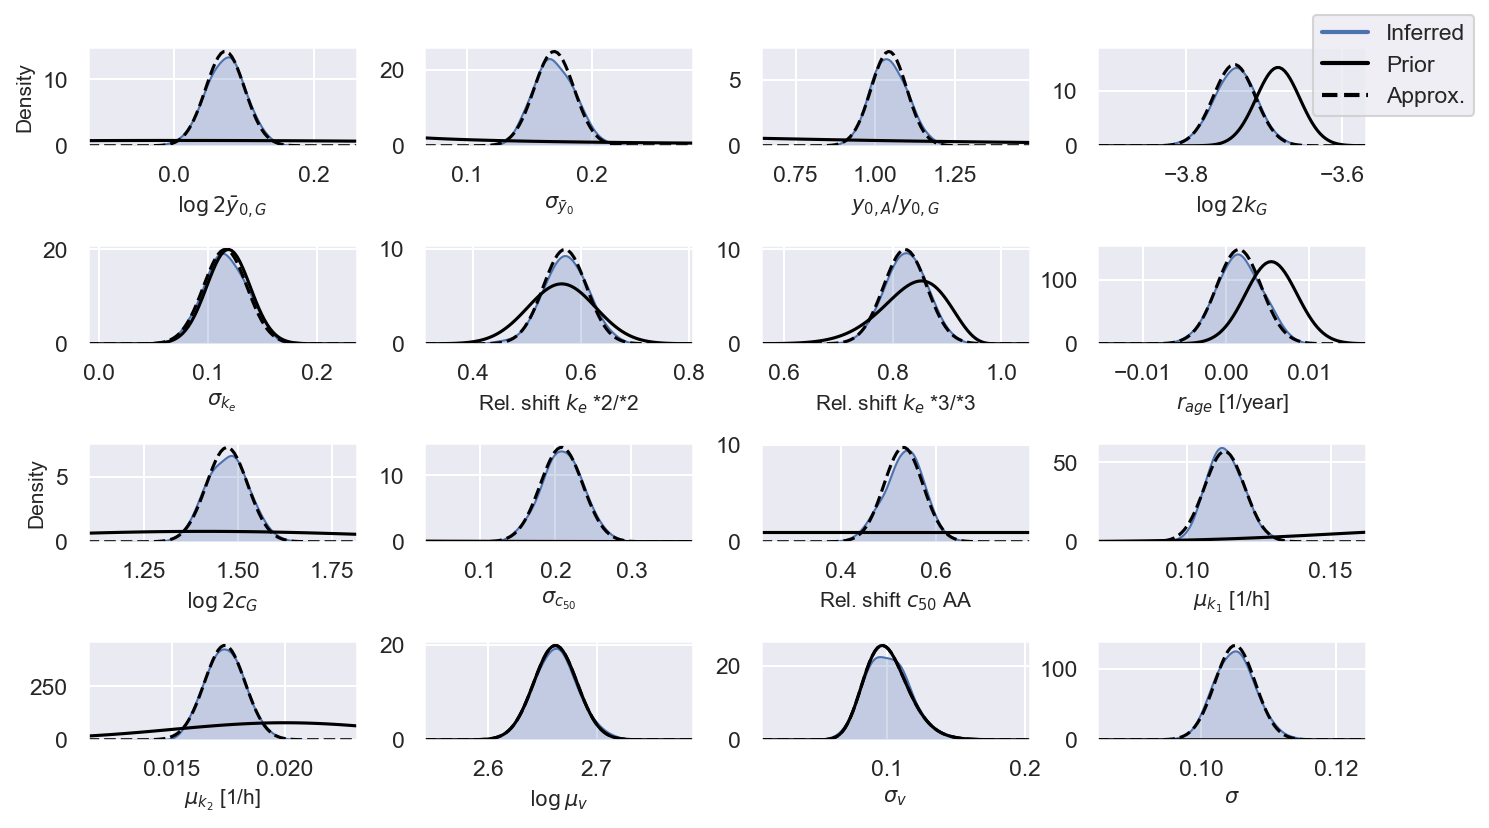

In [210]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(4, 4, hspace=1, wspace=0.25)

# Create axes for marginal posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes.append(plt.Subplot(fig, outer[4]))
axes.append(plt.Subplot(fig, outer[5]))
axes.append(plt.Subplot(fig, outer[6]))
axes.append(plt.Subplot(fig, outer[7]))
axes.append(plt.Subplot(fig, outer[8]))
axes.append(plt.Subplot(fig, outer[9]))
axes.append(plt.Subplot(fig, outer[10]))
axes.append(plt.Subplot(fig, outer[11]))
axes.append(plt.Subplot(fig, outer[12]))
axes.append(plt.Subplot(fig, outer[13]))
axes.append(plt.Subplot(fig, outer[14]))
axes.append(plt.Subplot(fig, outer[15]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 10000
pop_parameters = np.vstack([
    posterior['Log mean myokit.baseline_inr'].values.flatten(),
    posterior['Log std. myokit.baseline_inr'].values.flatten(),
    posterior['Rel. baseline INR A'].values.flatten(),
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 8], fill=True, ax=axes[8], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 9], fill=True, ax=axes[9], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 10], fill=True, ax=axes[10], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 11], fill=True, ax=axes[11], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 12], fill=True, ax=axes[12], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 13], fill=True, ax=axes[13], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 14], fill=True, ax=axes[14], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 15], fill=True, ax=axes[15], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(0, 0.5),            # Mean log baseline INR G
    pints.LogNormalLogPrior(-1, 2),            # Std. log baseline INR
    pints.LogNormalLogPrior(0, 1),             # Mean log baseline INR A
    pints.GaussianLogPrior(-3.682, 0.028),     # Mean log clearance
    pints.GaussianLogPrior(0.119, 0.020),      # Sigma log clearance
    pints.GaussianLogPrior(0.565, 0.063),      # Rel. shift clearance CYP29P *2
    pints.BetaLogPrior(30, 6),                 # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00546, 0.0031),   # Rel. shift clearance Age
    pints.GaussianLogPrior(1.41, 0.5),         # Mean log EC50
    pints.GaussianLogPrior(-1, 0.5),           # Sigma log EC50
    pints.UniformLogPrior(0, 1),               # Rel. shift EC50 VKORC1 A
    pints.GaussianLogPrior(0.2, 0.05),         # Transition rate chain 1
    pints.GaussianLogPrior(0.02, 0.005),       # Transition rate chain 2
    pints.GaussianLogPrior(2.662, 0.020),      # Mean log volume
    pints.LogNormalLogPrior(-2.31, 0.16),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)           # Sigma log INR
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    axes[idp].plot(xs, evals, color='black')
    axes[idp].set_xlim([min_value, max_value])

# Plot approximate posteriors
log_priors = [
    pints.GaussianLogPrior(0.073, 0.028),      # Mean log baseline INR G
    pints.GaussianLogPrior(0.170, 0.016),      # Std. log baseline INR
    pints.GaussianLogPrior(1.043, 0.056),      # Mean log baseline INR A
    pints.GaussianLogPrior(-3.738, 0.027),     # Mean log clearance
    pints.GaussianLogPrior(0.116, 0.02),       # Sigma log clearance
    pints.GaussianLogPrior(0.571, 0.04),       # Rel. shift clearance CYP29P *2
    pints.GaussianLogPrior(0.823, 0.04),       # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00157, 0.0027),   # Rel. shift clearance Age
    pints.GaussianLogPrior(1.471, 0.055),      # Mean log EC50
    pints.GaussianLogPrior(0.208, 0.028),      # Sigma log EC50
    pints.GaussianLogPrior(0.532, 0.041),      # Rel. shift EC50 VKORC1 A
    pints.GaussianLogPrior(0.113, 0.007),      # Transition rate chain 1
    pints.GaussianLogPrior(0.01735, 0.0009),   # Transition rate chain 2
    pints.GaussianLogPrior(2.662, 0.020),      # Mean log volume
    pints.LogNormalLogPrior(-2.31, 0.16),      # Sigma log volume
    pints.GaussianLogPrior(0.105, 0.003)       # Sigma log INR
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Add legends
axes[3].set_ylim([0, 18])
axes[3].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[3].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='Prior', linewidth=2)
axes[3].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Approx.', linewidth=2)
axes[3].legend(loc=[0.8, 0.3])

# Label axes
axes[0].set_xlabel(r'$\log 2\bar{y}_{0, G}$', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel(r'$\sigma _{\bar{y}_0}$', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel(r'$y_{0, A} / y_{0, G}$', fontsize=fontsize)
axes[2].set_ylabel('', fontsize=fontsize)
axes[3].set_xlabel(r'$\log 2k_{G}$', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel(r'$\sigma _{k_e}$', fontsize=fontsize)
axes[4].set_ylabel('', fontsize=fontsize)
axes[5].set_xlabel(r'Rel. shift $k_e$ *2/*2', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel(r'Rel. shift $k_e$ *3/*3', fontsize=fontsize)
axes[6].set_ylabel('', fontsize=fontsize)
axes[7].set_xlabel(r'$r_{age}$ [1/year]', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)
axes[8].set_xlabel(r'$\log 2c_{G}$', fontsize=fontsize)
axes[8].set_ylabel('Density', fontsize=fontsize)
axes[9].set_xlabel(r'$\sigma _{c_{50}}$', fontsize=fontsize)
axes[9].set_ylabel('', fontsize=fontsize)
axes[10].set_xlabel(r'Rel. shift $c_{50}$ AA', fontsize=fontsize)
axes[10].set_ylabel('', fontsize=fontsize)
axes[11].set_xlabel(r'$\mu_{k_1}$ [1/h]', fontsize=fontsize)
axes[11].set_ylabel('', fontsize=fontsize)
axes[12].set_xlabel(r'$\mu_{k_2}$ [1/h]', fontsize=fontsize)
axes[12].set_ylabel('', fontsize=fontsize)
axes[13].set_xlabel(r'$\log \mu _{v}$', fontsize=fontsize)
axes[13].set_ylabel('', fontsize=fontsize)
axes[14].set_xlabel(r'$\sigma _{v}$', fontsize=fontsize)
axes[14].set_ylabel('', fontsize=fontsize)
axes[15].set_xlabel(r'$\sigma$', fontsize=fontsize)
axes[15].set_ylabel('', fontsize=fontsize)

plt.savefig('4_trial_phase_2_approximate_posteriors.pdf', bbox_inches='tight')
plt.savefig('4_trial_phase_2_approximate_posteriors.tif', bbox_inches='tight')

plt.show()

## Calibrate to trial phase III

Import data

In [231]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_III.csv')

# Keep only steady state measurement
mask = \
    (data.Observable != 'INR') | (
    (data.Observable == 'INR') & (data.Time == 1320))
data = data[mask]

# Define model
mechanistic_model, _ = define_steady_state_hamberg_model()
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        BaselineINRCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(centered=False)])
population_model = chi.ReducedPopulationModel(population_model)
population_model.fix_parameters({
    'Log mean Dim. 1': 0.073,
    'Log std. Dim. 1': 0.170,
    'Rel. baseline INR A': 1.043,
    'Log std. Dim. 2': 0.116,
    'Log std. Dim. 3': 0.208,
    'Log std. Dim. 4': 0.101
})

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_III.nc')

Reshape data

In [232]:
# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
inrs_3 = np.empty(shape=len(ids))
doses_3 = np.empty(shape=(len(ids)))
covariates_3 = np.empty(shape=(len(ids), 4))
for idx, _id in enumerate(ids):
    inrs_3[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses_3[idx] = data[mask].Dose.dropna().values[-1]
    covariates_3[idx, 0] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]
    covariates_3[idx, 1] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates_3[idx, 2] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates_3[idx, 3] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten()
    ]).T
indiv_parameters = np.vstack([
    posterior['myokit.baseline_inr'].values,
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.half_maximal_effect_concentration'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 4))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates_3)

duration = 0.01
times_3 = [100]  # Does not influence the simulation (Steady state)
indiv_fits_3 = np.empty(shape=(n_samples, len(ids), len(times_3)))
for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
    # Set dosing regimen
    mechanistic_model.set_dosing_regimen(dose=doses_3[idd], period=24)
    for idx, sample in enumerate(indiv_params):
        indiv_fits_3[idx, idd] = mechanistic_model.simulate(
            sample, times_3)[0]

cov_model0 = BaselineINRCovariateModel()
cov_model1 = HambergEliminationRateCovariateModel()
cov_model2 = HambergEC50CovariateModel()
pop_fits_3 = np.empty(shape=(n_samples, len(ids), len(times_3)))
for idd, covs in enumerate(covariates_3):
    # Set dosing regimen
    mechanistic_model.set_dosing_regimen(dose=doses_3[idd], period=24)
    for idx, samples in enumerate(pop_parameters):
        log_y0, _ = cov_model0.compute_population_parameters(
            parameters=np.array([1.772]),
            pop_parameters=np.array([0.348, 0.187])[:, np.newaxis],
            covariates=covs[np.newaxis, :1])[0, :, 0]
        log_ke, _ = cov_model1.compute_population_parameters(
            parameters=samples[1:4],
            pop_parameters=np.array([samples[0], 0.116])[:, np.newaxis],
            covariates=covs[np.newaxis, 1:3])[0, :, 0]
        log_ec50, _ = cov_model2.compute_population_parameters(
            parameters=samples[5:6],
            pop_parameters=np.array([samples[4], 0.208])[:, np.newaxis],
            covariates=covs[np.newaxis, 3:])[0, :, 0]
        pop_fits_3[idx, idd] = mechanistic_model.simulate(
            parameters=[
                np.exp(log_y0),
                np.exp(log_ke),
                np.exp(log_ec50),
                np.exp(samples[6])
                ],
            times=times_3)[0]

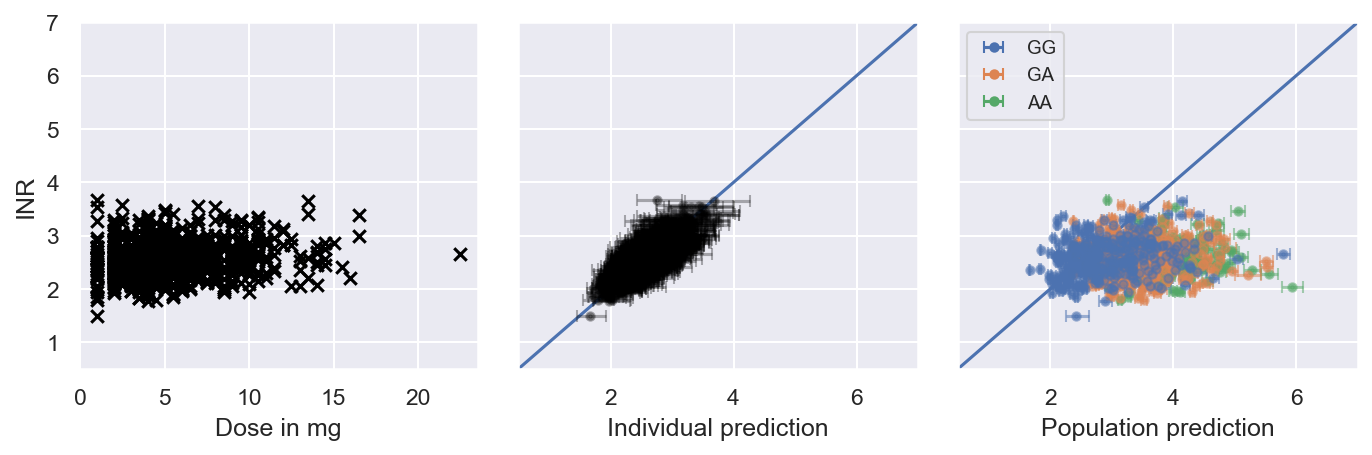

In [236]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
axes[0].scatter(
    doses_3, inrs_3, marker='x', color='black')

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_3, axis=0)
fifth = medians - np.percentile(indiv_fits_3, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_3, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, inrs_3[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, inrs_3[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_3, axis=0)
fifth = medians - np.percentile(pop_fits_3, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_3, axis=0, q=95) - medians
covs = covariates_3[:, 1:]
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, inrs_3[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covs[idf, 2])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, inrs_3[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covs[idf, 2])])

# Add legend to population residuals
labels = ['GG', 'GA', 'AA']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Dose in mg')
axes[0].set_ylabel('INR')
axes[1].set_xlabel('Individual prediction')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction')
axes[2].set_ylabel('')
axes[0].set_ylim([0.5, 7])
axes[1].set_xlim([0.5, 7])
axes[2].set_xlim([0.5, 7])

plt.savefig('5_trial_phase_3.pdf', bbox_inches='tight')
plt.savefig('5_trial_phase_3.tif', bbox_inches='tight')

plt.show()

Summarise demographics

In [93]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 1] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 1] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 1] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 1] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 1] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 1] == 5) / len(covariates))
print('Fraction with GG: ', np.sum(covariates[:, 3] == 0) / len(covariates))
print('Fraction with GA: ', np.sum(covariates[:, 3] == 1) / len(covariates))
print('Fraction with AA: ', np.sum(covariates[:, 3] == 2) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 2]),
        np.percentile(covariates[:, 2], q=5),
        np.percentile(covariates[:, 2], q=95)))

Fraction with *1/*1:  0.661
Fraction with *1/*2:  0.184
Fraction with *1/*3:  0.123
Fraction with *2/*2:  0.014
Fraction with *2/*3:  0.012
Fraction with *3/*3:  0.006
Fraction with GG:  0.365
Fraction with GA:  0.485
Fraction with AA:  0.15
Age: 65 (55 - 76)


Plot marginal distributions

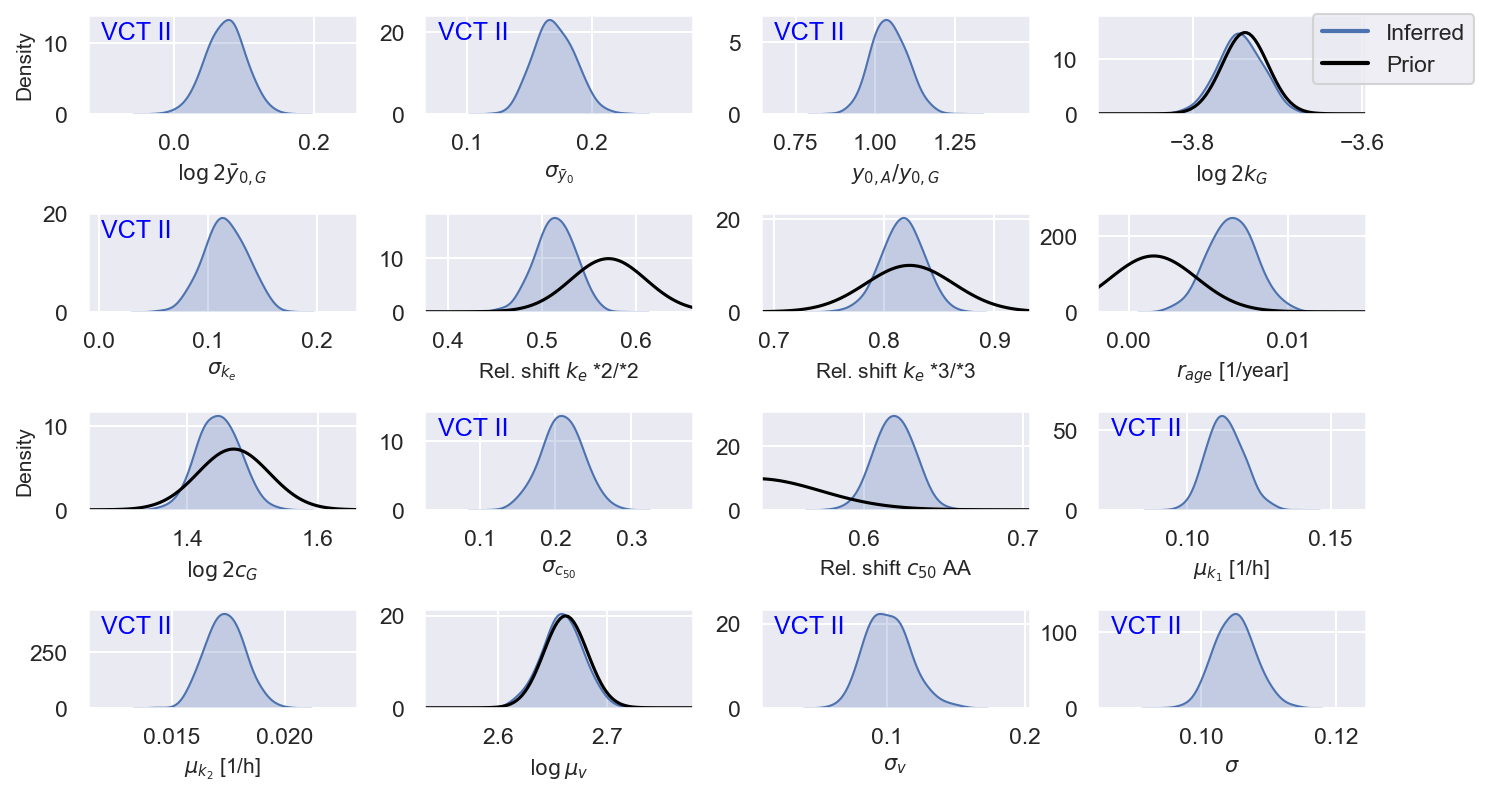

In [237]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(4, 4, hspace=1, wspace=0.25)

# Create axes for marginal posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes.append(plt.Subplot(fig, outer[4]))
axes.append(plt.Subplot(fig, outer[5]))
axes.append(plt.Subplot(fig, outer[6]))
axes.append(plt.Subplot(fig, outer[7]))
axes.append(plt.Subplot(fig, outer[8]))
axes.append(plt.Subplot(fig, outer[9]))
axes.append(plt.Subplot(fig, outer[10]))
axes.append(plt.Subplot(fig, outer[11]))
axes.append(plt.Subplot(fig, outer[12]))
axes.append(plt.Subplot(fig, outer[13]))
axes.append(plt.Subplot(fig, outer[14]))
axes.append(plt.Subplot(fig, outer[15]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
directory = os.getcwd()
posterior2 = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_II.nc')
seed = np.random.default_rng(3)
n_samples = 10000
pop_parameters = np.vstack([
    posterior2['Log mean myokit.baseline_inr'].values.flatten(),
    posterior2['Log std. myokit.baseline_inr'].values.flatten(),
    posterior2['Rel. baseline INR A'].values.flatten(),
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior2['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior2[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior2['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior2['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior2['Log std. myokit.volume'].values.flatten(),
    posterior2['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 8], fill=True, ax=axes[8], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 9], fill=True, ax=axes[9], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 10], fill=True, ax=axes[10], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 11], fill=True, ax=axes[11], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 12], fill=True, ax=axes[12], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 13], fill=True, ax=axes[13], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 14], fill=True, ax=axes[14], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 15], fill=True, ax=axes[15], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(0.073, 0.028),      # Mean log baseline INR G
    pints.GaussianLogPrior(0.170, 0.016),      # Std. log baseline INR
    pints.GaussianLogPrior(1.043, 0.056),      # Mean log baseline INR A
    pints.GaussianLogPrior(-3.738, 0.027),     # Mean log clearance
    pints.GaussianLogPrior(0.116, 0.02),       # Sigma log clearance
    pints.GaussianLogPrior(0.571, 0.04),       # Rel. shift clearance CYP29P *2
    pints.GaussianLogPrior(0.823, 0.04),       # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00157, 0.0027),   # Rel. shift clearance Age
    pints.GaussianLogPrior(1.471, 0.055),      # Mean log EC50
    pints.GaussianLogPrior(0.208, 0.028),      # Sigma log EC50
    pints.GaussianLogPrior(0.532, 0.041),      # Rel. shift EC50 VKORC1 A
    pints.GaussianLogPrior(0.113, 0.007),      # Transition rate chain 1
    pints.GaussianLogPrior(0.01735, 0.0009),   # Transition rate chain 2
    pints.GaussianLogPrior(2.662, 0.020),      # Mean log volume
    pints.LogNormalLogPrior(-2.31, 0.16),      # Sigma log volume
    pints.GaussianLogPrior(0.105, 0.003)       # Sigma log INR
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    axes[idp].set_xlim([min_value, max_value])
    if idp in [0, 1, 2, 4, 9, 11, 12, 14, 15]:
        axes[idp].annotate(
            "VCT II", xy=(0, 0.37), xytext=(0.05, 0.75),
            xycoords=axes[idp].transAxes, color='blue')
        continue
    axes[idp].plot(xs, evals, color='black')

# Add legends
axes[3].set_ylim([0, 18])
axes[3].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[3].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='Prior', linewidth=2)
axes[3].legend(loc=[0.8, 0.3])

# Label axes
axes[0].set_xlabel(r'$\log 2\bar{y}_{0, G}$', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel(r'$\sigma _{\bar{y}_0}$', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel(r'$y_{0, A} / y_{0, G}$', fontsize=fontsize)
axes[2].set_ylabel('', fontsize=fontsize)
axes[3].set_xlabel(r'$\log 2k_{G}$', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel(r'$\sigma _{k_e}$', fontsize=fontsize)
axes[4].set_ylabel('', fontsize=fontsize)
axes[5].set_xlabel(r'Rel. shift $k_e$ *2/*2', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel(r'Rel. shift $k_e$ *3/*3', fontsize=fontsize)
axes[6].set_ylabel('', fontsize=fontsize)
axes[7].set_xlabel(r'$r_{age}$ [1/year]', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)
axes[8].set_xlabel(r'$\log 2c_{G}$', fontsize=fontsize)
axes[8].set_ylabel('Density', fontsize=fontsize)
axes[9].set_xlabel(r'$\sigma _{c_{50}}$', fontsize=fontsize)
axes[9].set_ylabel('', fontsize=fontsize)
axes[10].set_xlabel(r'Rel. shift $c_{50}$ AA', fontsize=fontsize)
axes[10].set_ylabel('', fontsize=fontsize)
axes[11].set_xlabel(r'$\mu_{k_1}$ [1/h]', fontsize=fontsize)
axes[11].set_ylabel('', fontsize=fontsize)
axes[12].set_xlabel(r'$\mu_{k_2}$ [1/h]', fontsize=fontsize)
axes[12].set_ylabel('', fontsize=fontsize)
axes[13].set_xlabel(r'$\log \mu _{v}$', fontsize=fontsize)
axes[13].set_ylabel('', fontsize=fontsize)
axes[14].set_xlabel(r'$\sigma _{v}$', fontsize=fontsize)
axes[14].set_ylabel('', fontsize=fontsize)
axes[15].set_xlabel(r'$\sigma$', fontsize=fontsize)
axes[15].set_ylabel('', fontsize=fontsize)

plt.savefig('6_trial_phase_3_approximate_posteriors.pdf', bbox_inches='tight')
plt.savefig('6_trial_phase_3_approximate_posteriors.tif', bbox_inches='tight')

plt.show()

## Combined results

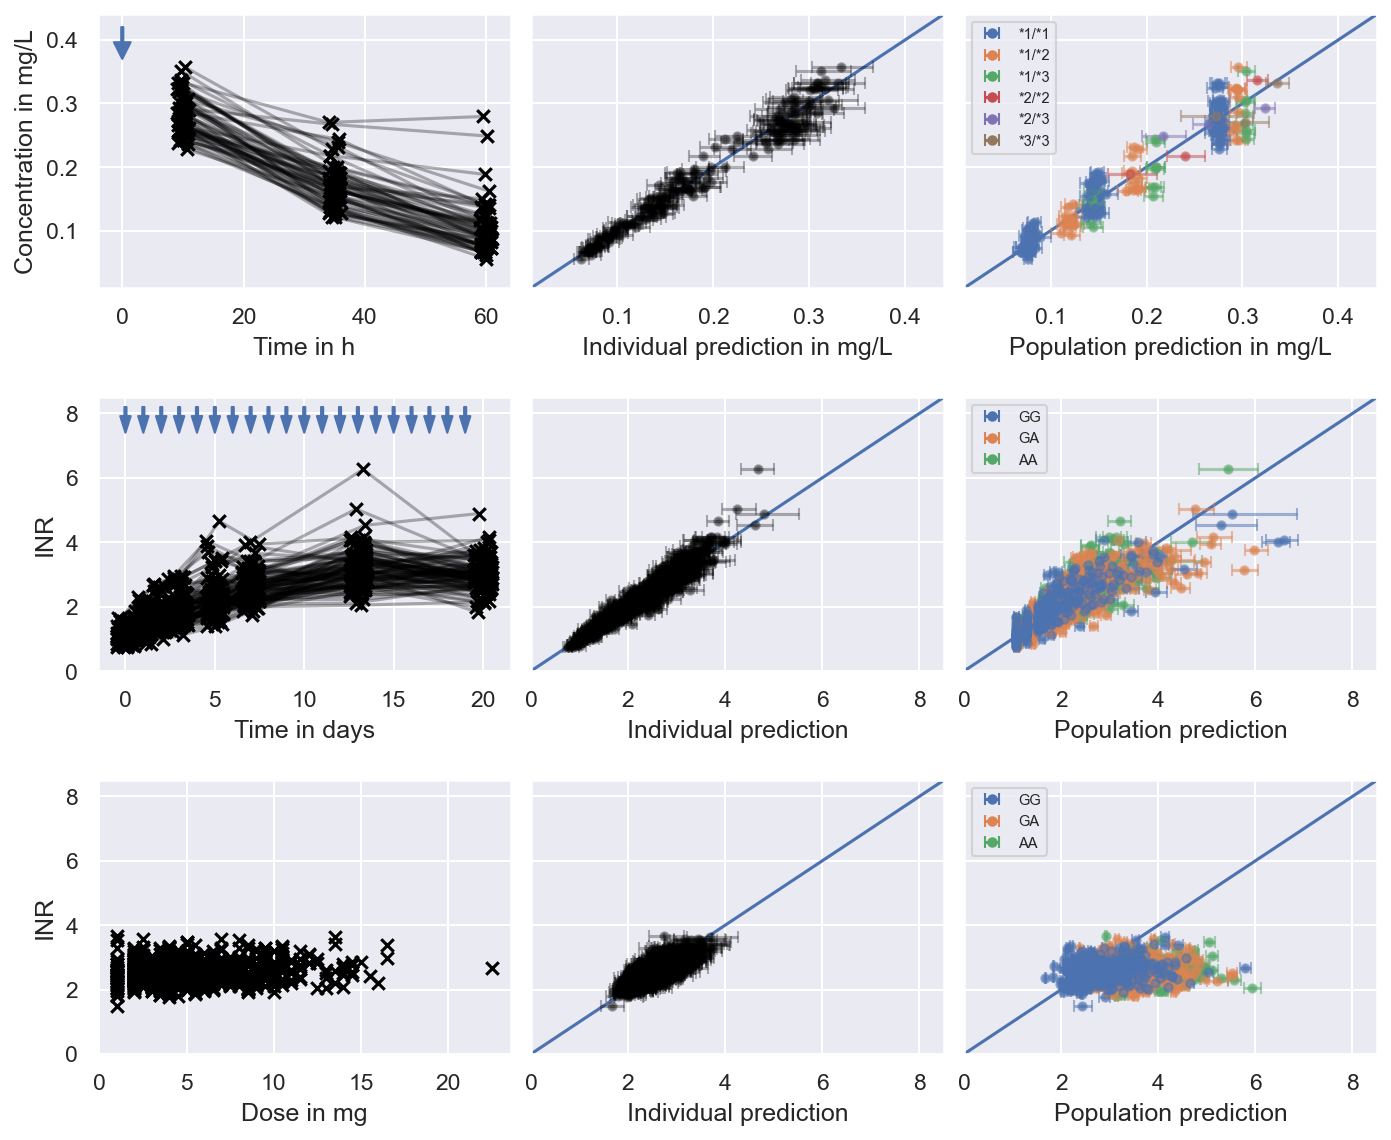

In [239]:
# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1800 // my_dpi), dpi=150)
outer = gridspec.GridSpec(3, 1, hspace=0.4)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[2], wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[2]))

# Share y axis
axes[0].sharey(axes[1])
axes[1].sharey(axes[2])
axes[3].sharey(axes[4])
axes[4].sharey(axes[5])
axes[6].sharey(axes[7])
axes[7].sharey(axes[8])


# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Visualise measurements
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times + jitter, c, marker='x', color='black')

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.37), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=8, headlength=8,
    color=sns.color_palette()[0]))

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_1, axis=0)
fifth = medians - np.percentile(indiv_fits_1, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_1, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_1, axis=0)
fifth = medians - np.percentile(pop_fits_1, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_1, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, concs[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates_1[idf, 0])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, concs[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates_1[idf, 0])])

# Add legend to population residuals
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual prediction in mg/L')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction in mg/L')
axes[2].set_ylabel('')
axes[0].set_ylim([0.01, 0.44])
axes[0].set_xlim([-4, 64])
axes[1].set_ylim([0.01, 0.44])
axes[1].set_xlim([0.01, 0.44])
axes[2].set_ylim([0.01, 0.44])
axes[2].set_xlim([0.01, 0.44])
axes[1].set_yticklabels(labels=[], visible=False)
axes[2].set_yticklabels(labels=[], visible=False)

# Visualise measurements
for c in inrs2:
    jitter = np.random.uniform(-0.5, 0.5, size=len(times2))
    axes[3].plot(
        times2 + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[3].scatter(
        times2 + jitter, c, marker='x', color='black')

# Visualise dosing regimen
for t in np.arange(20):
    axes[3].annotate(
        "", xy=(t, 7.4), xytext=(t, 8.2),
        arrowprops=dict(width=1, headwidth=5, headlength=8,
        color=sns.color_palette()[0]))

# Visualise residuals
axes[4].plot(
    [0, 1], [0, 1], transform=axes[4].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_2, axis=0)
fifth = medians - np.percentile(indiv_fits_2, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_2, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[4].errorbar(
        f, inrs2[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[4].scatter(
        f, inrs2[idf], marker='o', color='black', alpha=0.3, s=4)

axes[5].plot(
    [0, 1], [0, 1], transform=axes[5].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_2, axis=0)
fifth = medians - np.percentile(pop_fits_2, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_2, axis=0, q=95) - medians
covs = covariates_2[:, 1:]
for idf, f in enumerate(medians):
    axes[5].errorbar(
        f, inrs2[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covs[idf, 2])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[5].scatter(
        f, inrs2[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covs[idf, 2])])

# Add legend to population residuals
labels = ['GG', 'GA', 'AA']
for idl, label in enumerate(labels):
    axes[5].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[5].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[3].set_xlabel('Time in days')
axes[3].set_ylabel('INR')
axes[4].set_xlabel('Individual prediction')
axes[4].set_ylabel('')
axes[5].set_xlabel('Population prediction')
axes[5].set_ylabel('')
axes[3].set_ylim([0, 8.5])
axes[4].set_yticklabels(labels=[], visible=False)
axes[5].set_yticklabels(labels=[], visible=False)
axes[4].set_xlim([0, 8.5])
axes[5].set_xlim([0, 8.5])

# Visualise measurements
axes[6].scatter(
    doses_3, inrs_3, marker='x', color='black')

# Visualise residuals
axes[7].plot(
    [0, 1], [0, 1], transform=axes[7].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_3, axis=0)
fifth = medians - np.percentile(indiv_fits_3, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_3, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[7].errorbar(
        f, inrs_3[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[7].scatter(
        f, inrs_3[idf], marker='o', color='black', alpha=0.3, s=4)

axes[8].plot(
    [0, 1], [0, 1], transform=axes[8].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_3, axis=0)
fifth = medians - np.percentile(pop_fits_3, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_3, axis=0, q=95) - medians
covs = covariates_3[:, 1:]
for idf, f in enumerate(medians):
    axes[8].errorbar(
        f, inrs_3[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covs[idf, 2])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[8].scatter(
        f, inrs_3[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covs[idf, 2])])

# Add legend to population residuals
labels = ['GG', 'GA', 'AA']
for idl, label in enumerate(labels):
    axes[8].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[8].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[6].set_xlabel('Dose in mg')
axes[6].set_ylabel('INR')
axes[7].set_xlabel('Individual prediction')
axes[7].set_ylabel('')
axes[8].set_xlabel('Population prediction')
axes[8].set_ylabel('')
axes[6].set_ylim([0, 8.5])
axes[7].set_yticklabels(labels=[], visible=False)
axes[8].set_yticklabels(labels=[], visible=False)
axes[7].set_xlim([0, 8.5])
axes[8].set_xlim([0, 8.5])

plt.savefig('7_calibration_of_hamberg_model.pdf', bbox_inches='tight')
plt.savefig('7_calibration_of_hamberg_model.tif', bbox_inches='tight')

plt.show()

## Derive prior for an example individual from the MIPD cohort

In [240]:
# Define model
model = define_hamberg_population_model(
        centered=True, conc=False, fixed_y0=False)

# Get individual from cohort
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/mipd_trial_cohort.csv')
ids = data.ID.unique()
data = data[data.ID == ids[-1]]

# Reshape into covariate matrix [VKORC1, CYP, Age, VKORC]
ids = data.ID.dropna().unique()
covariates = np.empty(shape=(len(ids), 4))
for idx, _id in enumerate(ids):
    temp = data[data.ID == _id]
    covariates[idx, 0] = temp['VKORC1'].values
    covariates[idx, 1] = temp['CYP2C9'].values
    covariates[idx, 2] = temp['Age'].values
    covariates[idx, 3] = temp['VKORC1'].values

# Define parameters
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_III.nc')
posterior2 = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_II.nc')
parameters = np.vstack([
    posterior2['Log mean myokit.baseline_inr'].values.flatten(),
    posterior2['Log std. myokit.baseline_inr'].values.flatten(),
    posterior2['Rel. baseline INR A'].values.flatten(),
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior2['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior2[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior2['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior2['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior2['Log std. myokit.volume'].values.flatten(),
    posterior2['Pooled Sigma log'].values.flatten()]).T

# Define samples from prior
n_samples = len(parameters)
n_ids = len(covariates)
n_dim = model.n_dim()
prior_samples = np.empty(shape=(n_samples, n_ids, n_dim))
for ids, sample in enumerate(parameters):
    prior_samples[ids] = model.sample(
        parameters=sample, covariates=covariates, n_samples=n_ids,
        seed=ids)

In [241]:
covariates

array([[ 0.        ,  0.        , 54.48418209,  0.        ]])

Visualise prior

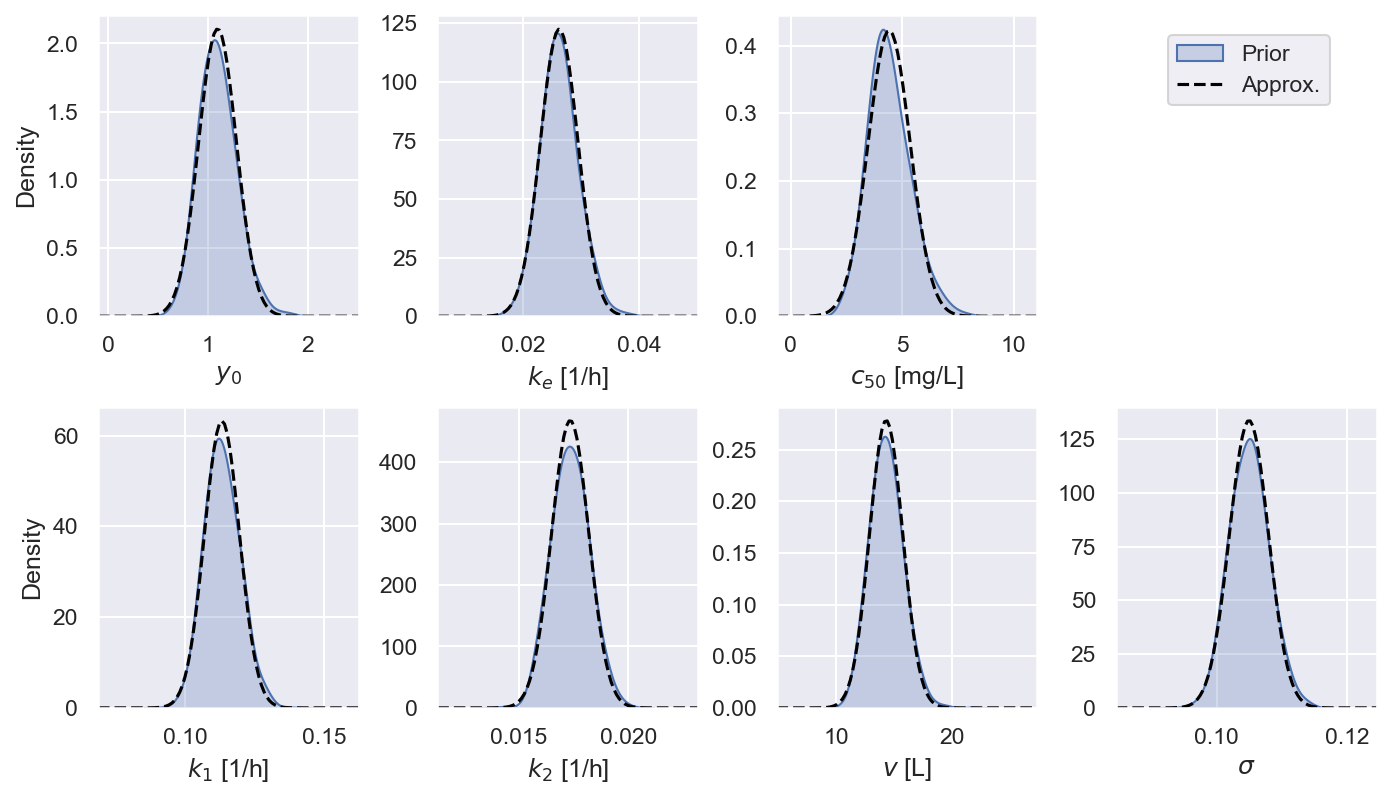

In [242]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 4, hspace=0.3, wspace=0.3)

# Create axes for marginal posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[4]))
axes.append(plt.Subplot(fig, outer[5]))
axes.append(plt.Subplot(fig, outer[6]))
axes.append(plt.Subplot(fig, outer[7]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot exact priors
for ida, ax in enumerate(axes):
    sns.kdeplot(
        x=prior_samples[:, 0, ida], fill=True, ax=ax, bw_adjust=1.5,
        label='Prior')

# Plot approximate priors
log_priors = [
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 0]),
        np.std(prior_samples[:, 0, 0], ddof=1)),      # y_0
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 1]),
        np.std(prior_samples[:, 0, 1], ddof=1)),      # k_e
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 2]),
        np.std(prior_samples[:, 0, 2], ddof=1)),      # c_50
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 3]),
        np.std(prior_samples[:, 0, 3], ddof=1)),      # k_1
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 4]),
        np.std(prior_samples[:, 0, 4], ddof=1)),      # k_2
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 5]),
        np.std(prior_samples[:, 0, 5], ddof=1)),      # v
    pints.GaussianLogPrior(
        np.mean(prior_samples[:, 0, 6]),
        np.std(prior_samples[:, 0, 6], ddof=1)),      # sigma
]
for idp in range(7):
    param = prior_samples[:, 0, idp]
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    axes[idp].set_xlim([min_value, max_value])
    axes[idp].plot(xs, evals, color='black', linestyle='--', label='Approx.')

# Label plots
axes[0].set_xlabel(r'$y_0$')
axes[1].set_xlabel(r'$k_e$ [1/h]')
axes[2].set_xlabel(r'$c_{50}$ [mg/L]')
axes[3].set_xlabel(r'$k_1$ [1/h]')
axes[4].set_xlabel(r'$k_2$ [1/h]')
axes[5].set_xlabel(r'$v$ [L]')
axes[6].set_xlabel(r'$\sigma$')

axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[4].set_ylabel('')
axes[5].set_ylabel('')
axes[6].set_ylabel('')

axes[2].legend(loc=[1.5, 0.7])

plt.savefig('8_example_prior_for_11_GG_individual.pdf', bbox_inches='tight')
plt.savefig('8_example_prior_for_11_GG_individual.tif', bbox_inches='tight')

plt.show()